# Example notebook

In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = './external/data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
# checkpoint = torch.load('model_best_val_loss_var.pkl')

# model.load_state_dict(checkpoint['model_state'])
# model.eval()
# model.cuda()
# print("Model loaded.")

ModuleNotFoundError: No module named 'floortrans'

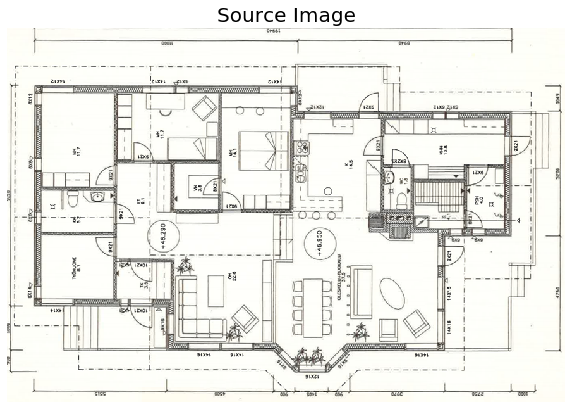

In [2]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image']#.cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= data_folder+folder+"model.svg", width=800)

## Parsed labels

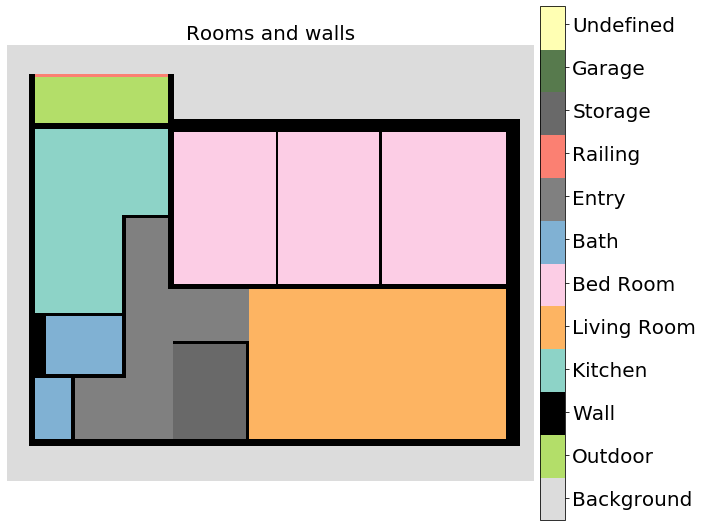

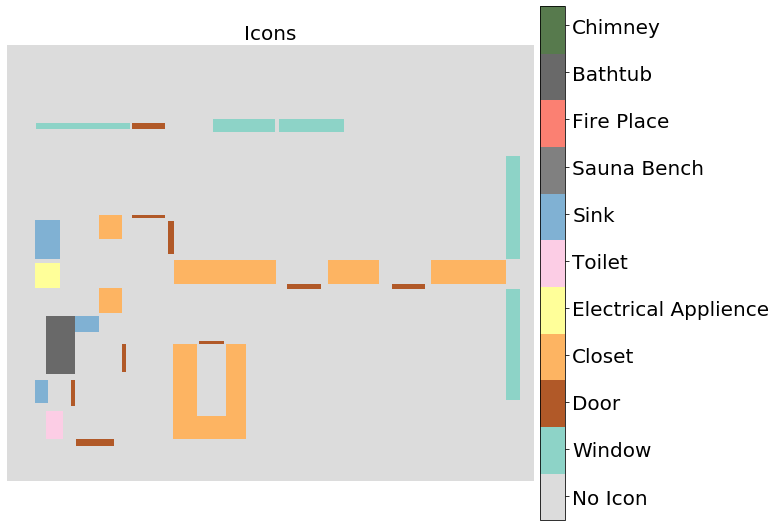

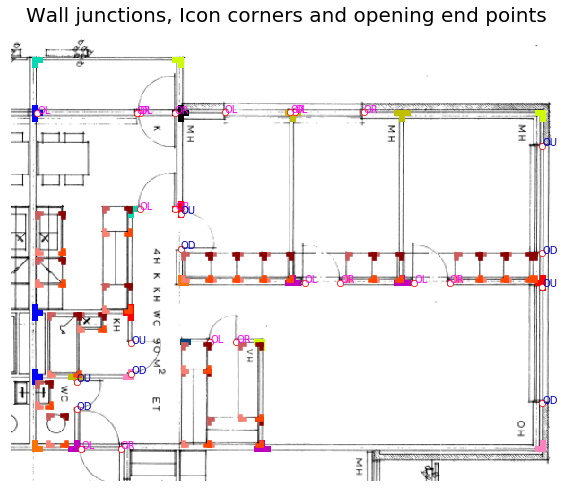

In [23]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

In [29]:
junctions

{0: [],
 1: [],
 2: [],
 3: [[tensor([195]), tensor([350])]],
 4: [[tensor([597]), tensor([469])], [tensor([138]), tensor([389])]],
 5: [[tensor([30]), tensor([469])], [tensor([193]), tensor([284])]],
 6: [[tensor([30]), tensor([35])], [tensor([138]), tensor([202])]],
 7: [[tensor([597]), tensor([95])],
  [tensor([193]), tensor([35])],
  [tensor([284]), tensor([350])]],
 8: [[tensor([318]), tensor([95])],
  [tensor([440]), tensor([95])],
  [tensor([77]), tensor([389])]],
 9: [[tensor([597]), tensor([284])],
  [tensor([193]), tensor([202])],
  [tensor([138]), tensor([317])]],
 10: [[tensor([77]), tensor([469])],
  [tensor([284]), tensor([469])],
  [tensor([318]), tensor([284])],
  [tensor([440]), tensor([284])]],
 11: [[tensor([30]), tensor([95])],
  [tensor([30]), tensor([389])],
  [tensor([30]), tensor([317])]],
 12: [[tensor([193]), tensor([95])]],
 13: [[tensor([82]), tensor([469])],
  [tensor([331]), tensor([284])],
  [tensor([453]), tensor([284])],
  [tensor([242]), tensor([94])],